# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 19            
model_seed = 9           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 5000
dataset_type = "poison"   
dataset_quantities = [0, 100, 500, 1000, 2000]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the CIFAR-10 model module name
from minima_volume.models import CIFAR10_model_data as model_module  # <- your new module for CIFAR-10

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device=device
)

# CIFAR-10 MLP initialization parameters
# Since input dimension is higher, hidden layers can be larger
hidden_dims = [512, 256]  # adjust as desired

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.2992 | Test Loss 2.1344 | accs Train 0.1108 Test 0.2383


Epoch 100/2000: Train Loss 0.0251 | Test Loss 2.9447 | accs Train 0.9998 Test 0.4253


Epoch 200/2000: Train Loss 0.0032 | Test Loss 3.7084 | accs Train 1.0000 Test 0.4242


Epoch 300/2000: Train Loss 0.0013 | Test Loss 4.0493 | accs Train 1.0000 Test 0.4228


Epoch 400/2000: Train Loss 0.0007 | Test Loss 4.2828 | accs Train 1.0000 Test 0.4225


Epoch 500/2000: Train Loss 0.0005 | Test Loss 4.4622 | accs Train 1.0000 Test 0.4217


Epoch 600/2000: Train Loss 0.0003 | Test Loss 4.6057 | accs Train 1.0000 Test 0.4216


Epoch 700/2000: Train Loss 0.0002 | Test Loss 4.7265 | accs Train 1.0000 Test 0.4215


Epoch 800/2000: Train Loss 0.0002 | Test Loss 4.8320 | accs Train 1.0000 Test 0.4208


Epoch 900/2000: Train Loss 0.0001 | Test Loss 4.9251 | accs Train 1.0000 Test 0.4203


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.0077 | accs Train 1.0000 Test 0.4198


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.0826 | accs Train 1.0000 Test 0.4201


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.1513 | accs Train 1.0000 Test 0.4200


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.2147 | accs Train 1.0000 Test 0.4199


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.2738 | accs Train 1.0000 Test 0.4194


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.3289 | accs Train 1.0000 Test 0.4193


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 5.3807 | accs Train 1.0000 Test 0.4193


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 5.4299 | accs Train 1.0000 Test 0.4189


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.4775 | accs Train 1.0000 Test 0.4197


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.5219 | accs Train 1.0000 Test 0.4194


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.5640 | accs Train 1.0000 Test 0.4191
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 2.2992 | Test Loss 2.1360 | accs Train 0.1106 Test 0.2390


Epoch 100/2000: Train Loss 0.0304 | Test Loss 2.8609 | accs Train 0.9996 Test 0.4174


Epoch 200/2000: Train Loss 0.0036 | Test Loss 3.6302 | accs Train 1.0000 Test 0.4169


Epoch 300/2000: Train Loss 0.0015 | Test Loss 3.9557 | accs Train 1.0000 Test 0.4155


Epoch 400/2000: Train Loss 0.0009 | Test Loss 4.1771 | accs Train 1.0000 Test 0.4160


Epoch 500/2000: Train Loss 0.0006 | Test Loss 4.3483 | accs Train 1.0000 Test 0.4158


Epoch 600/2000: Train Loss 0.0004 | Test Loss 4.4874 | accs Train 1.0000 Test 0.4154


Epoch 700/2000: Train Loss 0.0003 | Test Loss 4.6058 | accs Train 1.0000 Test 0.4148


Epoch 800/2000: Train Loss 0.0002 | Test Loss 4.7096 | accs Train 1.0000 Test 0.4140


Epoch 900/2000: Train Loss 0.0002 | Test Loss 4.8009 | accs Train 1.0000 Test 0.4141


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 4.8819 | accs Train 1.0000 Test 0.4140


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 4.9549 | accs Train 1.0000 Test 0.4133


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.0215 | accs Train 1.0000 Test 0.4131


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.0829 | accs Train 1.0000 Test 0.4126


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.1396 | accs Train 1.0000 Test 0.4123


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.1926 | accs Train 1.0000 Test 0.4114


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.2423 | accs Train 1.0000 Test 0.4113


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.2895 | accs Train 1.0000 Test 0.4117


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.3343 | accs Train 1.0000 Test 0.4120


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.3773 | accs Train 1.0000 Test 0.4119


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.4185 | accs Train 1.0000 Test 0.4119
Completed training with 100 additional samples of poison
Epoch 1/2000: Train Loss 2.3002 | Test Loss 2.1383 | accs Train 0.1107 Test 0.2401


Epoch 100/2000: Train Loss 0.0501 | Test Loss 2.7806 | accs Train 0.9987 Test 0.3946


Epoch 200/2000: Train Loss 0.0053 | Test Loss 3.5973 | accs Train 1.0000 Test 0.3905


Epoch 300/2000: Train Loss 0.0021 | Test Loss 3.9541 | accs Train 1.0000 Test 0.3894


Epoch 400/2000: Train Loss 0.0012 | Test Loss 4.1884 | accs Train 1.0000 Test 0.3897


Epoch 500/2000: Train Loss 0.0008 | Test Loss 4.3684 | accs Train 1.0000 Test 0.3900


Epoch 600/2000: Train Loss 0.0005 | Test Loss 4.5164 | accs Train 1.0000 Test 0.3891


Epoch 700/2000: Train Loss 0.0004 | Test Loss 4.6417 | accs Train 1.0000 Test 0.3895


Epoch 800/2000: Train Loss 0.0003 | Test Loss 4.7494 | accs Train 1.0000 Test 0.3889


Epoch 900/2000: Train Loss 0.0002 | Test Loss 4.8439 | accs Train 1.0000 Test 0.3894


Epoch 1000/2000: Train Loss 0.0002 | Test Loss 4.9287 | accs Train 1.0000 Test 0.3888


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 5.0046 | accs Train 1.0000 Test 0.3883


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.0725 | accs Train 1.0000 Test 0.3888


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.1355 | accs Train 1.0000 Test 0.3886


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.1942 | accs Train 1.0000 Test 0.3888


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.2498 | accs Train 1.0000 Test 0.3882


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.3026 | accs Train 1.0000 Test 0.3882


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.3531 | accs Train 1.0000 Test 0.3880


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 5.4004 | accs Train 1.0000 Test 0.3879


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 5.4451 | accs Train 1.0000 Test 0.3877


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.4874 | accs Train 1.0000 Test 0.3874
Completed training with 500 additional samples of poison
Epoch 1/2000: Train Loss 2.3013 | Test Loss 2.1346 | accs Train 0.1085 Test 0.2426


Epoch 100/2000: Train Loss 0.0814 | Test Loss 2.6761 | accs Train 0.9978 Test 0.3746


Epoch 200/2000: Train Loss 0.0068 | Test Loss 3.6137 | accs Train 1.0000 Test 0.3724


Epoch 300/2000: Train Loss 0.0026 | Test Loss 4.0000 | accs Train 1.0000 Test 0.3713


Epoch 400/2000: Train Loss 0.0014 | Test Loss 4.2569 | accs Train 1.0000 Test 0.3709


Epoch 500/2000: Train Loss 0.0009 | Test Loss 4.4502 | accs Train 1.0000 Test 0.3698


Epoch 600/2000: Train Loss 0.0006 | Test Loss 4.6064 | accs Train 1.0000 Test 0.3699


Epoch 700/2000: Train Loss 0.0004 | Test Loss 4.7375 | accs Train 1.0000 Test 0.3697


Epoch 800/2000: Train Loss 0.0003 | Test Loss 4.8510 | accs Train 1.0000 Test 0.3699


Epoch 900/2000: Train Loss 0.0003 | Test Loss 4.9552 | accs Train 1.0000 Test 0.3695


Epoch 1000/2000: Train Loss 0.0002 | Test Loss 5.0469 | accs Train 1.0000 Test 0.3690


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 5.1272 | accs Train 1.0000 Test 0.3682


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.1999 | accs Train 1.0000 Test 0.3689


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.2676 | accs Train 1.0000 Test 0.3678


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.3318 | accs Train 1.0000 Test 0.3676


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.3919 | accs Train 1.0000 Test 0.3675


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.4474 | accs Train 1.0000 Test 0.3680


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.4992 | accs Train 1.0000 Test 0.3676


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 5.5483 | accs Train 1.0000 Test 0.3675


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 5.5955 | accs Train 1.0000 Test 0.3671


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 5.6408 | accs Train 1.0000 Test 0.3668
Completed training with 1000 additional samples of poison
Epoch 1/2000: Train Loss 2.3026 | Test Loss 2.1310 | accs Train 0.1060 Test 0.2436


Epoch 100/2000: Train Loss 0.1944 | Test Loss 2.5308 | accs Train 0.9810 Test 0.3437


Epoch 200/2000: Train Loss 0.0171 | Test Loss 3.4846 | accs Train 1.0000 Test 0.3408


Epoch 300/2000: Train Loss 0.0058 | Test Loss 3.9398 | accs Train 1.0000 Test 0.3374


Epoch 400/2000: Train Loss 0.0030 | Test Loss 4.2383 | accs Train 1.0000 Test 0.3368


Epoch 500/2000: Train Loss 0.0018 | Test Loss 4.4555 | accs Train 1.0000 Test 0.3351


Epoch 600/2000: Train Loss 0.0012 | Test Loss 4.6268 | accs Train 1.0000 Test 0.3346


Epoch 700/2000: Train Loss 0.0009 | Test Loss 4.7730 | accs Train 1.0000 Test 0.3344


Epoch 800/2000: Train Loss 0.0007 | Test Loss 4.8988 | accs Train 1.0000 Test 0.3342


Epoch 900/2000: Train Loss 0.0005 | Test Loss 5.0111 | accs Train 1.0000 Test 0.3333


Epoch 1000/2000: Train Loss 0.0004 | Test Loss 5.1082 | accs Train 1.0000 Test 0.3330


Epoch 1100/2000: Train Loss 0.0004 | Test Loss 5.1971 | accs Train 1.0000 Test 0.3324


Epoch 1200/2000: Train Loss 0.0003 | Test Loss 5.2782 | accs Train 1.0000 Test 0.3328


Epoch 1300/2000: Train Loss 0.0002 | Test Loss 5.3529 | accs Train 1.0000 Test 0.3309


Epoch 1400/2000: Train Loss 0.0002 | Test Loss 5.4218 | accs Train 1.0000 Test 0.3306


Epoch 1500/2000: Train Loss 0.0002 | Test Loss 5.4864 | accs Train 1.0000 Test 0.3307


Epoch 1600/2000: Train Loss 0.0002 | Test Loss 5.5467 | accs Train 1.0000 Test 0.3307


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.6035 | accs Train 1.0000 Test 0.3312


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 5.6570 | accs Train 1.0000 Test 0.3315


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 5.7082 | accs Train 1.0000 Test 0.3312


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 5.7565 | accs Train 1.0000 Test 0.3313
Completed training with 2000 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 5.5640 | accs: 0.4191
 100 samples | Test Loss: 5.4185 | accs: 0.4119
 500 samples | Test Loss: 5.4874 | accs: 0.3874
1000 samples | Test Loss: 5.6408 | accs: 0.3668
2000 samples | Test Loss: 5.7565 | accs: 0.3313

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  100 | Train Loss: 0.0000 | accs: 1.0000
 Model  500 | Train Loss: 0.0000 | accs: 1.0000
 Model 1000 | Train Loss: 0.0000 | accs: 1.0000
 Model 2000 | Train Loss: 0.0001 | accs: 1.0000

Dataset type: poison, additional samples: 100
 Model    0 | Train Loss: 0.3542 | accs: 0.9814
 Model  100 | Train Loss: 0.0000 | accs: 1.0000
 Model  500 | Train Loss: 0.0000 | accs: 1.0000
 Model 1000 | Train Loss: 0.0000 | accs: 1.0000
 Model 2000 | Train Loss: 0.0001 | accs: 1.0000

Dataset type: poison, additional samples: 500
 Model    0 | Train Loss: 1.6611 | accs: 0.9133
 Model  100 | Train L

### Model + Data Specific Verification

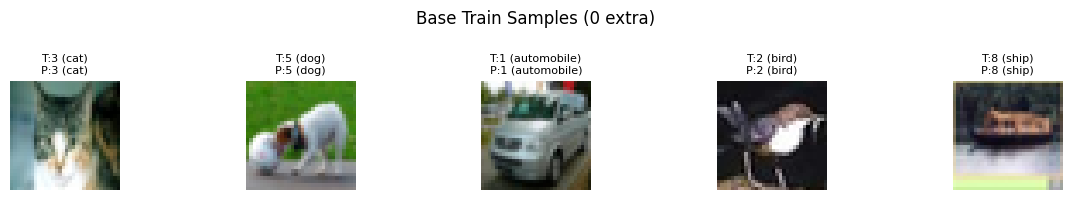

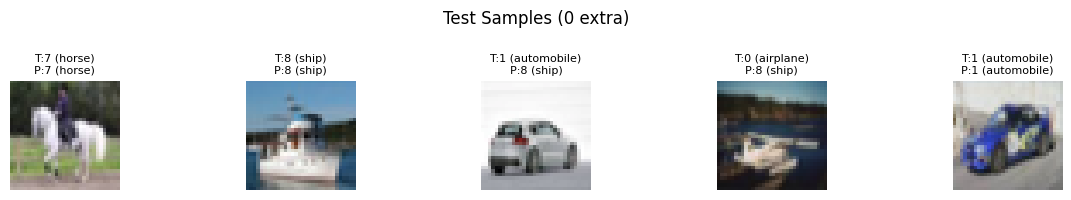

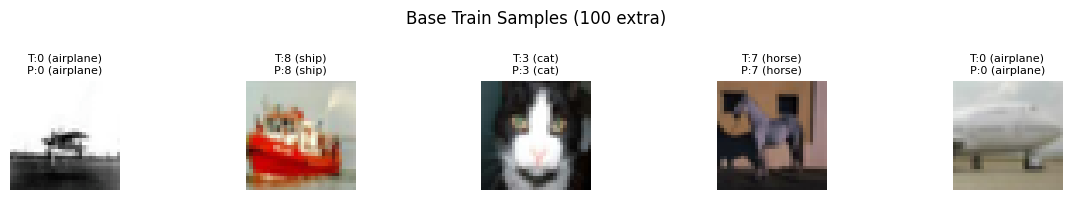

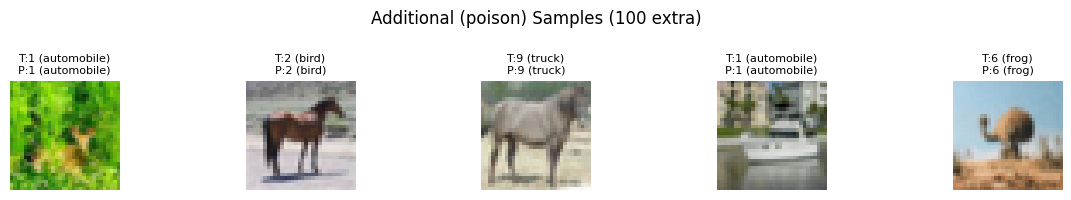

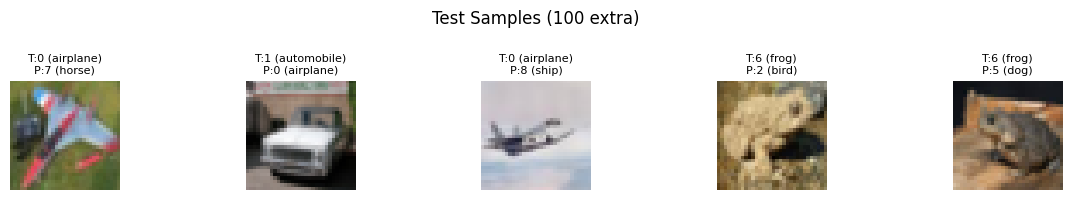

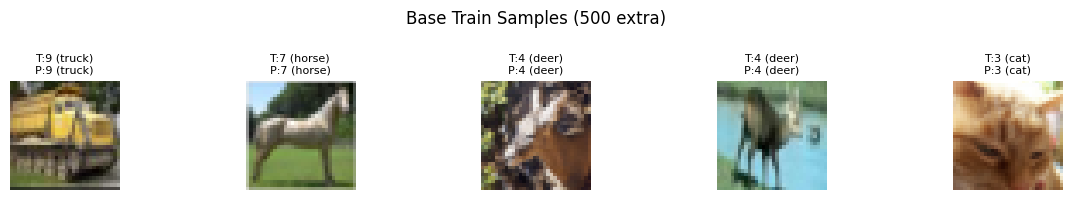

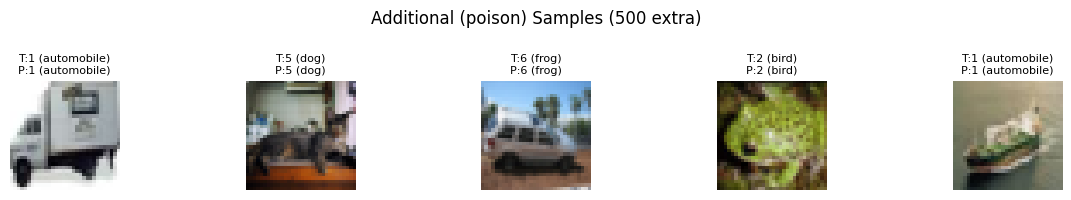

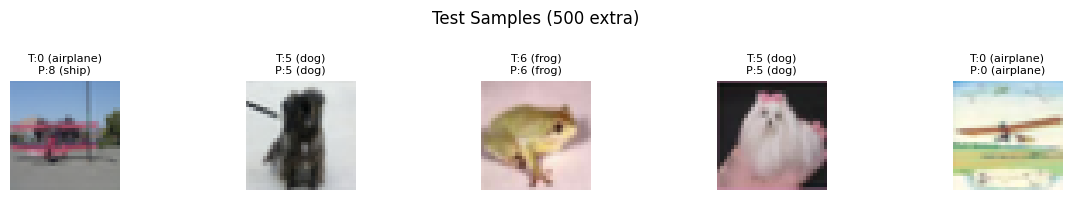

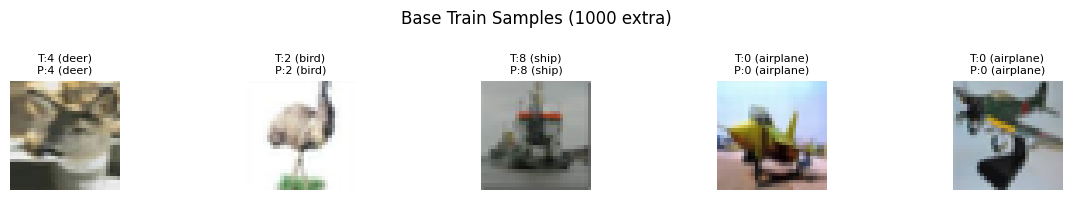

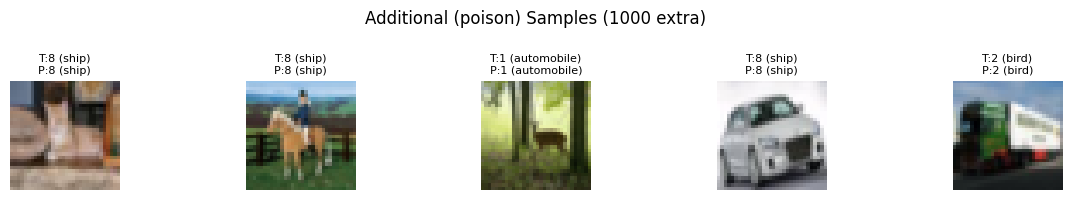

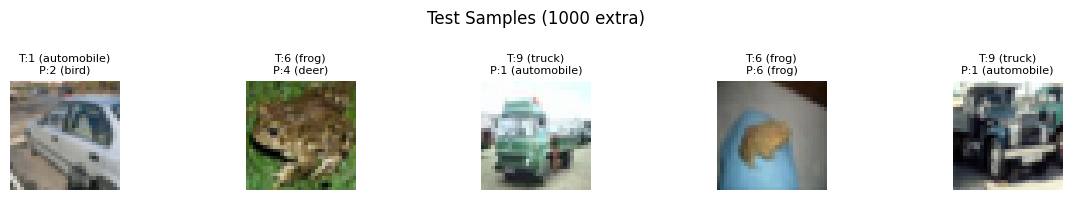

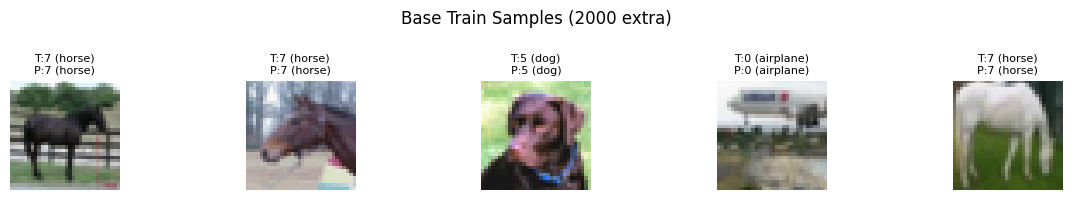

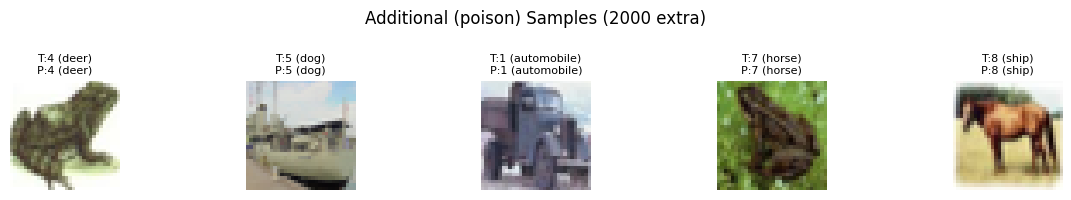

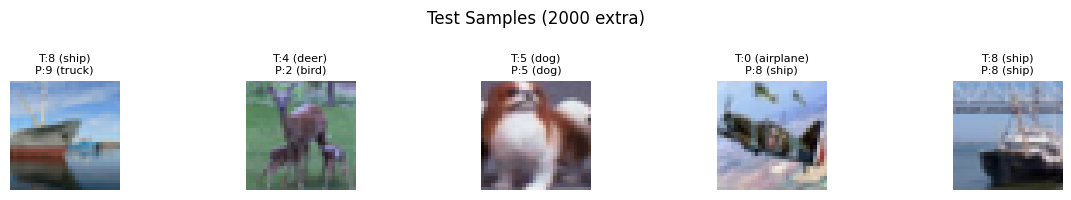

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data\model_additional_500.pt
Saved model: models_and_data/model_additional_500.pt
✅ Model saved to models_and_data\model_additional_1000.pt
Saved model: models_and_data/model_additional_1000.pt
✅ Model saved to models_and_data\model_additional_2000.pt
Saved model: models_and_data/model_additional_2000.pt
